# **Ajuste de hiperparámetros**

En este notebook practicaremos los distintos métodos de búsqueda automática de los mejores hiperparámetros vistos en la sesión de teoría.



# Obtención de los datos

Vamos a utilizar la base de datos Diabetes del repositorio StatLib. Es una base de datos habitual para hacer pruebas. El objetivo es construir un modelo que sea capaz de predecir la progresión de la diabetes a un año a partir de carácterísticas personales y datos de analíticas de sangre.

Cargamos directament la BD desde los datasets de sklearn. 
La base de datos contiene información sobre 442 pacientes de 10 variables diferentes. Podemos encontrar más información sobre la base de datos en [[1]](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html) [[2]](https://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf).

In [18]:
from sklearn import datasets

diabetes_BD = datasets.load_diabetes()
print(diabetes_BD.DESCR)


.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

Esta base de datos tiene variables como la edad, el sexo, el índice de masa corporal, la presión arterial, y otras derivadas de la analítica en sangre. Queremos inferir una variable cuantitativa que representa la progresión de la enfermedad a un año. Se trata por lo tanto de un problema de regresión.

Miramos las primeras filas de la base de datos.

In [19]:
import pandas as pd
df=pd.DataFrame(data=diabetes_BD.data,columns=diabetes_BD.feature_names)
target=pd.DataFrame(data=diabetes_BD.target,columns=['target'])
df=pd.concat([df,target],sort=True,axis=1)
df.head(15)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0
5,-0.092695,-0.044642,-0.040696,-0.019442,-0.068991,-0.079288,0.041277,-0.076395,-0.041180,-0.096346,97.0
6,-0.045472,0.050680,-0.047163,-0.015999,-0.040096,-0.024800,0.000779,-0.039493,-0.062913,-0.038357,138.0
7,0.063504,0.050680,-0.001895,0.066630,0.090620,0.108914,0.022869,0.017703,-0.035817,0.003064,63.0
8,0.041708,0.050680,0.061696,-0.040099,-0.013953,0.006202,-0.028674,-0.002592,-0.014956,0.011349,110.0
9,-0.070900,-0.044642,0.039062,-0.033214,-0.012577,-0.034508,-0.024993,-0.002592,0.067736,-0.013504,310.0


Las columnas son numéricas y no contienen valores nulos. Además, como indican en la información de la BD, las variables están estandarizadas (media 0 y varianza 1). 
Además, como vemos a continuación, no contienen valores nulos.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 41.4 KB


Separamos las variables que usaremos para inferir de la variable objetivo.

In [21]:
diabetes=diabetes_BD["data"] # Datos de a usar 
feature_names=diabetes_BD["feature_names"] # Nombre de las variables
diabetes_target=diabetes_BD["target"] # Dato a inferir.

In [22]:
diabetes.shape

(442, 10)

In [23]:
from scipy import stats
stats.describe(diabetes_target)

DescribeResult(nobs=442, minmax=(25.0, 346.0), mean=152.13348416289594, variance=5943.331347923785, skewness=0.43906639932477265, kurtosis=-0.8866436055681386)

Fijarse que la progresión media de la enfermedad es de unos 152 puntos con un mínimo de unos 25 y un máximo de 346.

# División en conjunto de entrenamiento y conjunto de test

Como se ha comentado en otras sesiones, el preprocesamiento puede tener un efecto muy grande en el rendimiento del modelo. Esta base de datos ya está preprocesada (variables estandarizadas, sin nulos...).

Dividimos el conjunto entrenamiento y test (20%)

In [24]:
from sklearn.model_selection import train_test_split
X_train,  X_test, y_train, y_test = train_test_split(diabetes, diabetes_target, test_size=0.2, random_state=42)

In [25]:
X_test.shape

(89, 10)

In [26]:
X_train.shape

(353, 10)

# Definición y entrenamiento de un modelo con los hiperparámetros por defecto

Elelgimos tres modelos: SVM, árbol de decisión y un random forest. 

Definimos primero los modelos de SVM para regresión ([SVR](https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2)) y árbol de decisión para regresión ([decision tree regressor](https://dev.to/nexttech/classification-and-regression-analysis-with-decision-trees-jgp)).

In [27]:
from sklearn.svm import SVR
svm_reg = SVR()
svm_reg.fit(X_train, y_train)

SVR()

In [28]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

## Validación cruzada de los modelos

Primero el SVM.

Usamos validación cruzada con k=3. (Nota: Habitualmente se usa una k=10. Usamos k=3 por motivo de que los modelos se entrenen más rápido en el laboratorio).

El conjunto de entrenamiento se divide en 3 partes de forma aleatoria, se entrena con 2 de ellas y se hace test con la tercera. El resultado es un array con 3 resultados.

In [29]:
import numpy as np

from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=3)
svm_rmse_scores = np.sqrt(-svm_scores)

La función de cross-validation de Scikit-Learn espera una función que marque que mayor es mejor en lugar de una funión de coste (menor es mejor), por ello la función score es el opuesto de del Error Cuadrático Medio (MSE). Así, el código anterior calcula -scores antes de hacer la raíz cuadrada del error cuadrático medio. Recordar que el RMSE nos permite interpretar el error cometido en las mismas unidades de la variable objetivo. 

Como tenemos 3 folds podemos hacer la media y calcular la desviación típica de los resultados.

In [30]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(svm_rmse_scores)

Scores: [75.44008165 74.32625658 71.84309681]
Mean: 73.86981167866297
Standard deviation: 1.503513984198996


Obtenermos un error medio cercano a 74 puntos.

Ahora, del árbol de decisión

In [31]:
scores = cross_val_score(tree_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=3)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [76.29903258 82.97314248 82.48973   ]
Mean: 80.58730168710123
Standard deviation: 3.0386796307312474


Obtenemos un resultado algo peor.

Tratamos de crear un Random Forest. Los fundamentos los explicaremos en el tema siguiente. Por ahora, saber simplemente que es un conjunto de árboles de decisión.



In [32]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.get_params() #Obtiene los valores de los hiperparámetros que se han usado al definir el modelo

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [33]:
scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=3)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [56.12612733 64.14891558 58.61625271]
Mean: 59.63043187364237
Standard deviation: 3.3528795940096567


Mejora el resultado con un error medio de aproximadamente 60 puntos.

# Ajustar los parámetros del modelo

# Grid Search

En lugar de probar parámetros manualmente, podemos indicar con qué hiperparámetros queremos experimentar y qué valores para ellos queremos probar. El método de búsqueda por cuadrícula evaluará todas las posibles combinaciones, usando validación cruzada. 


En el siguiente código se busca la mejor combinación para los parámetros 'n_estimators' con [30, 100, 300] y  'max_features' con [3, 6, 8, 'auto'] para los hiperparámetros de un RandomForestRegressor. 
Por defecto, ha usado antes 'n_estimators=100' y 'max_features=auto'

La búsqueda explorará 12 combinaciones del RandomForestRegressor, entrenará el modelo 3 veces (ya que hemos indicado 3-fold cross validation). En otras palabras, tendremos 12 × 3 = 36
rondas de entrenamiento. Puede llevarle un tiempo, pero obtendremos la mejor combinación de hiperparámetros.

Habitualmente se elige validación cruzada con 10 folds (o con 5). Elegimos aquí 3 para acelerar un poco los algoritmos en este laboratorio.

In [34]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    # 12 (3×4) combinaciones de hiperparámetros
    'n_estimators': [30, 100, 300],
    'max_features': [3, 6, 8, 'auto']
    }   

forest_reg = RandomForestRegressor(random_state=42) 
# entrena con 3 folds, es decir un total de 12*3=36 rondas de entrenamiento 
grid_search_RF = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='neg_mean_squared_error',
                           refit= True, verbose=2, n_jobs=-1)
grid_search_RF.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   10.3s finished


CPU times: user 784 ms, sys: 87.6 ms, total: 872 ms
Wall time: 10.9 s


Podemos acceder a la mejor combinación de hiperparámetros en *best_params_*:

In [35]:
grid_search_RF.best_params_

{'max_features': 3, 'n_estimators': 300}

También se pode acceder al mejor modelo directamente en *best_estimator_*:

In [36]:
grid_search_RF.best_estimator_

RandomForestRegressor(max_features=3, n_estimators=300, random_state=42)

Como el parámetro **refit** de GridSearchCV tiene el valor True (por defecto), entonces una vez encuentra el mejor modelo usando validación cruzada, se reentrena el mejor modelo con todos los datos de entrenamiento.

Accedemos al resultado del mejor modelo en *best_score_*

In [37]:
negative_mse = grid_search_RF.best_score_
rmse = np.sqrt(-negative_mse)
rmse

57.25330008381234

Podemos acceder al resultado de todos los estimadores testados durante la búsqueda por cuadrícula:

In [38]:
cvres = grid_search_RF.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

58.87807465618285 {'max_features': 3, 'n_estimators': 30}
57.52122537271336 {'max_features': 3, 'n_estimators': 100}
57.25330008381234 {'max_features': 3, 'n_estimators': 300}
59.3967947690589 {'max_features': 6, 'n_estimators': 30}
58.45983587918955 {'max_features': 6, 'n_estimators': 100}
57.98039799163481 {'max_features': 6, 'n_estimators': 300}
60.63682802688271 {'max_features': 8, 'n_estimators': 30}
59.335775330199624 {'max_features': 8, 'n_estimators': 100}
58.69285061929609 {'max_features': 8, 'n_estimators': 300}
60.15638993685321 {'max_features': 'auto', 'n_estimators': 30}
59.72461977282928 {'max_features': 'auto', 'n_estimators': 100}
58.99224792465137 {'max_features': 'auto', 'n_estimators': 300}


En este ejemplo, obtenemos la mejor solución para los hiperparámtros max_features = 3, n_estimators= 300. El RMSE para esta combinación es aproximadamente 57 puntos, que es mejor que la que obteníamos en nuestro primer intento.

## Ejercicios Grid Search. 

Trataremos de buscar una combinación adecuada de hiperparámetros para un modelo Support Vector Machine Regressor (`sklearn.svm.SVR`). Definimos a continuación el modelo.  

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
svm_reg = SVR()

PREGUNTA: ¿Qué parámetros ha utilizado por defecto el modelo?

In [40]:
#Solución


EJERCICIO:
Utilizar el métod de GridSearch para encontrar la mejor combinación de hiperparámetros para el hiperparámetro 'kernel', 'C' y 'gamma'.

En particular para: 

- 'kernel': ['linear'], 'C': [1.0, 3.0];

o

- 'kernel': ['rbf'], 'C': [1.0, 3.0, 5.0],        'gamma': [0.01, 0.1, 1.0]


(Poner entre corchetes [] dos listas {} separadas por una coma)

Usa cross validation con tres folds.

In [41]:
#SOLUCIÓN
param_grid = [
              {'kernel':['linear'], 'C': [1.0, 30.]},
              {'kernel': [1.0, 3.0, 5.0],'gamma': [0.01, 0.1, 1.0]}
             ]
grid_search_svm_reg = GridSearchCV(svm_reg, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)
grid_search_svm_reg.fit(X_train, y_train)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  33 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    0.2s finished


GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [1.0, 30.0], 'kernel': ['linear']},
                         {'gamma': [0.01, 0.1, 1.0],
                          'kernel': [1.0, 3.0, 5.0]}],
             scoring='neg_mean_squared_error', verbose=3)

PREGUNTA:
¿Qué RMSE alcanza la mejor solución?

In [42]:
#RESPUESTA 


PREGUNTA:
¿Cuál es la mejor combinación de hiperparámetros?

In [43]:
#RESPUESTA


EJERCICIO: Obtén los resultados de todos los hiperparámetros que ha probado. ¿Puedes extraer alguna conclusión sobre los parámetros usados en la mejor opción? Por ejemplo, si el parámetro elegido como mejor opción es el mayor (o menor) usado, podría valer la pena incluir mayores (o menores valores) para ese parámetro.

In [44]:
#RESPUESTA:
cvres = grid_search_RF.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],cvres["params"]):
  print(np.sqrt(-mean_score),params)

58.87807465618285 {'max_features': 3, 'n_estimators': 30}
57.52122537271336 {'max_features': 3, 'n_estimators': 100}
57.25330008381234 {'max_features': 3, 'n_estimators': 300}
59.3967947690589 {'max_features': 6, 'n_estimators': 30}
58.45983587918955 {'max_features': 6, 'n_estimators': 100}
57.98039799163481 {'max_features': 6, 'n_estimators': 300}
60.63682802688271 {'max_features': 8, 'n_estimators': 30}
59.335775330199624 {'max_features': 8, 'n_estimators': 100}
58.69285061929609 {'max_features': 8, 'n_estimators': 300}
60.15638993685321 {'max_features': 'auto', 'n_estimators': 30}
59.72461977282928 {'max_features': 'auto', 'n_estimators': 100}
58.99224792465137 {'max_features': 'auto', 'n_estimators': 300}


Parece que el mejor "C" es al máximo testeado. Por ello, es conveniente repetir la búsqueda borrando los valores pequeños de C y cambiándolos por otros mayores.

EJERCICIO (Opcional): Prueba a usar el kernel 'poly' con distintos valores para los parámetros 'C', 'gamma' y 'degree'; y el kernel 'sigmoid' con distintos valores para los parámetros 'C' y 'gamma'. Prueba también a cambiar el hiperparámetro 'epsilon' en todos los kernels ¿Consigues mejorar el resultado?

In [45]:
#SOLUCIÓN
%%time


UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


In [ ]:
#RESPUESTA El mejor modelo alcanza el siguiente score, (usando 3-fold cross validation):


# Curva de validación

Determina los resultados del modelo cuando varía el valor de un parámetro. Para ello realiza validación cruzada sobre el conjunto de entrenamiento y permite representar los resultados (sobre entrenamiento y validación) para detectar, por ejemplo, si variar un determinado valor produce sobreentrenamiento.

Es similar a una búsqueda en red pero con un único parámetro.



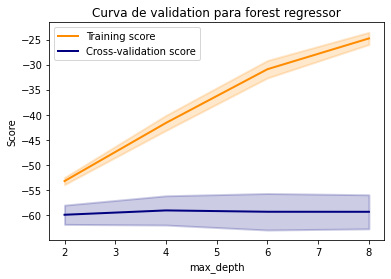

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

#Lista de parámetros
param_range = list(range(2,10,2)) 

#Curva de validación
train_scores, validation_scores = validation_curve(    
    forest_reg, X_train, y_train, param_name="max_depth", param_range=param_range,
    scoring='neg_root_mean_squared_error', cv=3, n_jobs=1)

#Pintamos la curva
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

plt.title("Curva de validation para forest regressor")
plt.xlabel(r"max_depth")
plt.ylabel("Score")
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, validation_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Se observa que variar el parámetro "máxima profundidad" mejora el entrenamiento, pero produce sobre-entrenamiento. De hecho aumenta ligeramente el resultado hasta 4 características y después disminuye.

## Ejercicios Curva de validación

EJERCICIO: Obtén la curva de validación para método de random forest anterior para el parámetro 'n_estimators' entre 10 y 200, con incrementos de 10. Da una interpretación a la gráfica obtenida.

In [47]:
# Solución


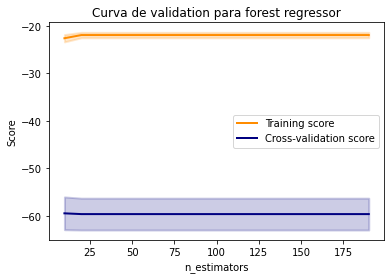

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

#Lista de parámetros
param_range = list(range(10,200,10)) 

#Curva de validación
train_scores, validation_scores = validation_curve(    
    forest_reg, X_train, y_train, param_name="max_depth", param_range=param_range,
    scoring='neg_root_mean_squared_error', cv=3, n_jobs=1)

#Pintamos la curva
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

plt.title("Curva de validation para forest regressor")
plt.xlabel(r"n_estimators")
plt.ylabel("Score")
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, validation_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

EJERCICIO (Opcional): Obtén la curva de validación para método de SVR anterior para el parámetro 'C' entre 0.1 y 40, con incrementos de 0.5. Da una interpretación a la gráfica obtenida.

In [49]:
#Solución


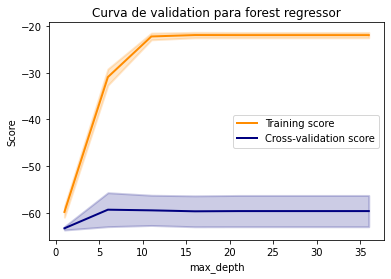

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

#Lista de parámetros
param_range = list(range(1,40,5)) 

#Curva de validación
train_scores, validation_scores = validation_curve(    
    forest_reg, X_train, y_train, param_name="max_depth", param_range=param_range,
    scoring='neg_root_mean_squared_error', cv=3, n_jobs=1)

#Pintamos la curva
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

plt.title("Curva de validation para forest regressor")
plt.xlabel(r"max_depth")
plt.ylabel("Score")
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, validation_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

# Random Search

La búsqueda aleatoria evalúa un número determinado de combinaciones seleccionando un valor aleatorio para cada hiperparámetro en cada iteración (en lugar de fijar los valores en los que buscar). Este enfoque tiene dos beneficios principales:

- Si se deja que la búsqueda aleatoria se realice para, digamos, 1.000 iteraciones, este enfoque explorará 1.000 valores diferentes para cada hiperparámetro (en lugar de sólo unos pocos valores por hiperparámetro con el enfoque de búsqueda en cuadrícula).
- Se tiene más control sobre la cantidad de computación que desea asignar a la búsqueda de hiperparámetros, simplemente estableciendo el número de iteraciones.

In [51]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# ver https://docs.scipy.org/doc/scipy/reference/stats.html
# para documentación sobre posibles funciones de distribución de probalidad.

param_distribs = {
        'n_estimators': randint(low=30, high=300), #A uniform discrete random variable.
        'max_features': randint(low=2, high=10)
    }

forest_reg = RandomForestRegressor(random_state=42) 

rnd_search_RF = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42, verbose=2, n_jobs=-1)

rnd_search_RF.fit(X_train, y_train)

negative_mse = rnd_search_RF.best_score_
rmse = np.sqrt(-negative_mse)
print("rmse del mejor modelo", rmse)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.0s finished


rmse del mejor modelo 57.380655404005566
CPU times: user 645 ms, sys: 25 ms, total: 670 ms
Wall time: 9.53 s


In [52]:
rnd_search_RF.best_params_

{'max_features': 3, 'n_estimators': 244}

Las opciones que ha probado son:

In [53]:
cvres = rnd_search_RF.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

59.01024058917472 {'max_features': 8, 'n_estimators': 136}
58.899733902105936 {'max_features': 9, 'n_estimators': 218}
58.438668465294924 {'max_features': 6, 'n_estimators': 132}
57.380655404005566 {'max_features': 3, 'n_estimators': 244}
57.461174101148394 {'max_features': 4, 'n_estimators': 117}
58.46932035459565 {'max_features': 6, 'n_estimators': 129}
58.827479879303425 {'max_features': 9, 'n_estimators': 181}
57.40578930884499 {'max_features': 4, 'n_estimators': 179}
57.943134856237585 {'max_features': 6, 'n_estimators': 287}
58.891985585400334 {'max_features': 9, 'n_estimators': 221}


Se obtiene un error similar (es un poco peor) probando 10 candidatos.

Vamos a evaluar los mejores modelos encontrados con grid search y con random search sobre el conjunto de test. 


In [54]:
from sklearn.metrics import mean_squared_error

final_model_grid_RF = grid_search_RF.best_estimator_

final_predictions_grid_RF = final_model_grid_RF.predict(X_test)

final_mse_grid = mean_squared_error(y_test, final_predictions_grid_RF)
final_rmse_grid = np.sqrt(final_mse_grid)
print('Mejor resultado con grid search sobre el conjunto de test',final_rmse_grid)

Mejor resultado con grid search sobre el conjunto de test 53.66166130378976


In [55]:
final_model_rnd_RF = rnd_search_RF.best_estimator_
final_predictions_rnd_RF = final_model_rnd_RF.predict(X_test)

final_mse_rnd = mean_squared_error(y_test, final_predictions_rnd_RF)
final_rmse_rnd = np.sqrt(final_mse_rnd)
print('Mejor resultado con random search sobre el conjunto de test', final_rmse_rnd)

Mejor resultado con random search sobre el conjunto de test 53.62728128823331


El rendimiento que obtenemos es un poco mejor en este caso, mirando menos alternativas. Debemos resistirnos a continuar haciendo ajuste de los hiperparámetros una vez testeado nuestro modelo en el conjunto de test, ya que las mejoras podrían no generalizarse a un nuevo conjunto de datos.

## Ejercicios Random Search.

EJERCICIO: Sobre el Ejercicio para Random Search para modelo Support Vector Machine Regressor cambiar la búsqueda GridSearchCV por una búsqueda RandomizedSearchCV.

Como distribuciones de búsqueda usar:

- Un lista ['linear', 'rbf'] para el parámetro 'kernel'
- loguniform(1, 20) para el parámetro 'C'
- expon(scale=1.0) para el parámetro 'gamma'

Utiliza un máximo de 10 modelos y cross validation con 3 folds.

Podemos encontrar en el siguiente [enlace](https://docs.scipy.org/doc/scipy/reference/stats.html) documentación para las funciones de distribución de probabilidad `expon()` y `loguniform()`.

In [56]:
#Respuesta



In [57]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


CPU times: user 20 µs, sys: 1e+03 ns, total: 21 µs
Wall time: 26.2 µs


PREGUNTA:
¿Cuál es el mejor RMSE que se obtiene?¿Cuáles son los hiperparámetros del modelo que obtiene este mejor resultado?

In [58]:
#RESPUESTA: El mejor modelo se obtiene:

In [59]:
#RESPUESTA: Los hiperparámetros que usa son:

PREGUNTA: ¿Se supera el resultado obtenido con Grid Search? ¿Qué parámetros obtienen el mejor resultado?

In [60]:
#Respueta

EJERCICIO (Opcional): Fijarse que hemos decidido usar una escala con distribución logarítmica uniforme para C y exponencial para 'gamma'. 
En el siguiente gráfico representamos estas distribuciones para 1000 elementos. Explica brevemente qué repercusión tiene la anterior decisión en los valores elegidos para estas variables. Atendiendo al valor óptimo que hemos obtenido para el parámetro C, ¿crees que ha sido una buena decisión elegir la distribución logarítmica para C? 

In [61]:
#Respuesta

EJERCICIO (Opcional): A la vista del resultado obtenido para C, ¿cambiarías de distribución estadística para este parámetro? Prueba a cambiar simplemente la escala a loguniform(1,200) y comprueba cuáles son los mejores valores para los hiperparámetros así como los resultados que obtienes tanto en el conjunto de validación como en el conjunto de test.

In [62]:
#RESPUESTA


# Optimización Bayesiana

Es un ejemplo de modelo secuencial que permiten utilizar los resultados de una iteración para mejorar el modelo en la siguiente. En particular permite construir un modelo de probabilidad bayesiano de la función objetivo y usarlo para seleccionar los parámetros más prometedores en la función objetivo real.



Existen varias librerías en python que han implementado métodos de optimización bayesiana. Entre ellas se encuentran [scikit-optimice](https://scikit-optimize.github.io/stable/) y [hyperopt](https://github.com/hyperopt/hyperopt).

Usamos a continuación el método BayesSearchCV de la librería scikit-optimize

In [63]:
! pip install scikit-optimize

In [64]:
from skopt import BayesSearchCV

In [65]:
%%time

from skopt.space import Real, Categorical, Integer #Permite definir el tipo
param_distribs_exp = {  #permite indicar la distribución de los parámetros
        'n_estimators': Integer(3, 300, 'uniform'), #Permite Integer, Categorical o Real
        'max_features': Integer(3, 8, 'uniform'), #Permite 'uniform' o 'log-uniform'
    }


forest_reg = RandomForestRegressor(random_state=42)

bayes_search_RF = BayesSearchCV(
    forest_reg,
    param_distribs_exp,
    n_iter=20,
    cv=3, scoring='neg_mean_squared_error', random_state=42,
    n_jobs=-1,
    optimizer_kwargs={'base_estimator': 'GP'} # 'GP': Gaussean Process,'RF': Random Forest regressor,'ET': Extra Trees regressor, 'GBRT': gradient boosted trees
  )
bayes_search_RF.fit(X_train, y_train)

print(bayes_search_RF.best_params_)
mean_score = bayes_search_RF.cv_results_['mean_test_score'][bayes_search_RF.best_index_]
print("score", np.sqrt(-mean_score))



/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


OrderedDict([('max_features', 3), ('n_estimators', 300)])
score 57.25330008381234
CPU times: user 13.3 s, sys: 6.48 s, total: 19.8 s
Wall time: 35.5 s


Obtiene un resultado similar.

In [66]:
cvres_bayes = bayes_search_RF.cv_results_
for mean_score, params in zip(cvres_bayes["mean_test_score"], cvres_bayes["params"]):
    print(np.sqrt(-mean_score), params)

57.60445972475531 OrderedDict([('max_features', 5), ('n_estimators', 219)])
58.14575573869346 OrderedDict([('max_features', 7), ('n_estimators', 265)])
57.45427014702818 OrderedDict([('max_features', 5), ('n_estimators', 276)])
58.503375740290586 OrderedDict([('max_features', 7), ('n_estimators', 54)])
58.408155383961294 OrderedDict([('max_features', 7), ('n_estimators', 133)])
58.127490777658885 OrderedDict([('max_features', 7), ('n_estimators', 282)])
58.10485735320156 OrderedDict([('max_features', 6), ('n_estimators', 233)])
57.9363960178765 OrderedDict([('max_features', 6), ('n_estimators', 276)])
58.69510218545334 OrderedDict([('max_features', 8), ('n_estimators', 211)])
57.40145660446197 OrderedDict([('max_features', 3), ('n_estimators', 246)])
57.318250488923816 OrderedDict([('max_features', 4), ('n_estimators', 300)])
65.49228227234809 OrderedDict([('max_features', 3), ('n_estimators', 3)])
57.36656082679393 OrderedDict([('max_features', 4), ('n_estimators', 270)])
57.338194790

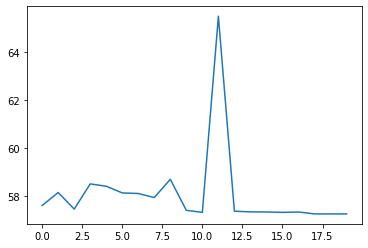

In [67]:
x = np.arange(0, 20)
plt.plot(x, [np.sqrt(-x) for x in cvres_bayes["mean_test_score"]])
plt.show()

Probamos en el conjunto de test.

In [68]:
from sklearn.metrics import mean_squared_error

final_model_bayes = bayes_search_RF.best_estimator_

final_predictions_bayes = final_model_bayes.predict(X_test)

final_mse_bayes = mean_squared_error(y_test, final_predictions_bayes)
final_rmse_bayes = np.sqrt(final_mse_bayes)
final_rmse_bayes




53.66166130378976

## Ejercicios Optimización bayesiana

EJERCICIO: Utiliza para el SVR() del ejemplo anterior el método BayesSearchCV. Usa el espacio de búsqueda que se propone. 

Utiliza el algoritmo 'ET' con 10 iteraciones.

¿Cuál es el mejor resultado que obtienes?¿Con qué configuración de parámetros?

In [69]:
from skopt.space import Real, Categorical, Integer
param_distribs_exp = {
        'kernel':  Categorical(['linear', 'rbf']),
        'C': Real(1, 20, 'log-uniform'),
        'gamma': Real(1e-6, 5, 'log-uniform'), 
    }


svm_reg = SVR()

In [73]:
# Solución

bayes_search_svm_reg = BayesSearchCV(
    svm_reg,
    param_distribs_exp,
    n_iter=50,
    cv=3, scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=2,
    optimizer_kwargs={'base_estimator': 'RF'} 
  )
bayes_search_svm_reg.fit(X_train, y_train)

print(bayes_search_RF.best_params_)
mean_score = bayes_search_RF.cv_results_['mean_test_score'][bayes_search_RF.best_index_]
print("score", np.sqrt(-mean_score))

negative_mse = grid_search_RF.best_score_
rmse = np.sqrt(-negative_mse)
print(rmse)



Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


AttributeError: ignored

EJERCICIO: Sobre el mismo espacio de búsqueda anterior y usando el algoritmo 'RF' y 50 iteraciones, obtén el resultado sobre el conjunto de entrenamiento de los 50 modelos. ¿Se observa una mejoría en la predicción a medida que se van obteniendo modelos?¿Por qué? Muestra la evolución de los resultados en una gráfica.

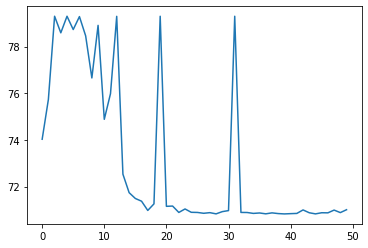

In [74]:
import matplotlib.pyplot as plt
x = np.arange(0, 50)
plt.plot(x, [np.sqrt(-x) for x in bayes_search_svm_reg.cv_results_["mean_test_score"]])
plt.show()



EJERCICIO: Obtén sobre el conjunto de test los resultados con el mejor método obtenido. ¿Mejora los métodos aplicados previamente sobre el SVR? 

In [ ]:
#Solución


EJERCICIO (Opcional). Prueba a cambiar los kernels, añadir hiperparámetros (por ejemplo 'epsilon' o 'degree') y/o aumentar el número de iteraciones. Comprueba si se obtiene alguna mejora sobre el conjunto de validación. Prueba a cambiar el estimador base: 'RF', 'GP', 'ET', 'GBRT'.  Finalmente, comprueba los resultados de la mejor opción sobre el conjunto de test.

In [75]:
from skopt.space import Real, Categorical, Integer
param_distribs_exp = {
        'kernel':  Categorical(['linear', 'rbf', 'poly']),
        'C': Real(1, 20, 'log-uniform'),
        'gamma': Real(1e-6, 5, 'log-uniform'),
        'epsilon': Real(1e-6, 5, 'log-uniform'), 
        'degree': [2, 3, 4] 
    }


svm_reg = SVR()

# Solución


In [ ]:
#Solución


# Hyperband

Implementa un algoritmo basado en la división de recursos. 

Este tipo de algoritmos para el ajuste de hiperparámetros se basan en el supuesto de que si una configuración está destinada a ser la mejor después de un gran número de iteraciones, es más probable que funcione en la mitad superior de las configuraciones después de un pequeño número de iteraciones. 

Así no se hace hincapié en el rendimiento absoluto de un algoritmo, sino más bien en su rendimiento relativo en comparación con muchas alternativas entrenadas para el mismo número de iteraciones.

En esta sesión cargamos la librería de hyperband que todavía no están actualizadas para la nueva versión scikit-learn.
Cargamos una versión anterior.
NOTA: Debemos reiniciar la sesión para que la actualización tenga efecto.

In [76]:
!pip install 'scikit-learn==0.23.2'
#Restart kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'restart': True, 'status': 'ok'}

Descargamos Hyperband y lo cargamos en Colab

In [1]:
%%capture
!git clone https://github.com/thuijskens/scikit-hyperband.git
%cd scikit-hyperband
!python setup.py install 



In [2]:
from hyperband import HyperbandSearchCV
import warnings
warnings.filterwarnings('ignore')

Cargamos la DB diabetes de nuevo y repartimos los conjuntos train y test como antes.

La volvemos a probar sobre el random forest.

In [3]:
from sklearn import datasets

diabetes_BD = datasets.load_diabetes()
print(diabetes_BD.DESCR)


.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [4]:
diabetes=diabetes_BD["data"] # Datos de las casas a usar 
feature_names=diabetes_BD["feature_names"] # Nombre de las variables
diabetes_target=diabetes_BD["target"] # Dato a inferir. Precio medio de las casas

In [5]:
from sklearn.model_selection import train_test_split
X_train,  X_test, y_train, y_test = train_test_split(diabetes, diabetes_target, test_size=0.2, random_state=42)

In [6]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)
forest_reg

RandomForestRegressor(random_state=42)

Vamos a aplicar el algoritmo a un Random Forest. 

Cuando se aplica a Random Forest, el parámetro que se ajusta en cada estimación (resource_param) suele ser el número de árboles. En este ejemplo, coincide que también es uno de los parámetros a combinar.

Añadimos algún parámetro más a probar como *max_depth* para aumentar el espacio de búsqueda. Recordar que n_estimators lo usaremos para ir repartiendo los recursos.


In [7]:
# Distributions or lists of parameters to try. Distributions must provide a rvs method for sampling (such as those from scipy.stats.distributions). If a list is given, it is sampled uniformly.
param_grid = {  
     #'n_estimators': [30, 100, 300, 500],
     'max_features': [2, 4, 6, 8],
     'max_depth' : [7, 9, None],
     }




max_iter y min_iter marcan el número máximo de árboles que se asinganarán a una combinación de hiperparámetros, y eta la reducción de recursos en cada iteración.

In [8]:
%%time

Hyb_search_RF = HyperbandSearchCV(forest_reg,
                           param_grid,
                           resource_param='n_estimators', #Recursos que se asignarán en cada estimacion. En Random Forest tipicamente el número de árboles
                           verbose =1,
                           max_iter=1000, #Numero de árboles máximo en una iteración
                           min_iter=30, #Numero de árboles mínimo en una iteración
                           eta=3, #Reducción de recursos en cada iteración, en este caso se reducira un tercio
                           cv=3,
                           scoring='neg_mean_squared_error',
                           random_state = 42)

Hyb_search_RF.fit(X_train, y_train)

Starting bracket 1 (out of 4) of hyperband
Starting successive halving iteration 1 out of 4. Fitting 12 configurations, with resource_param n_estimators set to 37, and keeping the best 9 configurations.
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 2 out of 4. Fitting 9 configurations, with resource_param n_estimators set to 111, and keeping the best 3 configurations.
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 3 out of 4. Fitting 3 configurations, with resource_param n_estimators set to 333, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 4 out of 4. Fitting 1 configurations, with resource_param n_estimators set to 1000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting bracket 2 (out of 4) of hyperband
Starting successive halving iteration 1 out of 3. Fitting 9 configurations, with resource_param n_estimators set to 111, and keeping the best 3 configurations.
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 2 out of 3. Fitting 3 configurations, with resource_param n_estimators set to 333, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 3 out of 3. Fitting 1 configurations, with resource_param n_estimators set to 1000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting bracket 3 (out of 4) of hyperband
Starting successive halving iteration 1 out of 2. Fitting 6 configurations, with resource_param n_estimators set to 333, and keeping the best 2 configurations.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 2 out of 2. Fitting 2 configurations, with resource_param n_estimators set to 1000
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting bracket 4 (out of 4) of hyperband
Starting successive halving iteration 1 out of 1. Fitting 4 configurations, with resource_param n_estimators set to 1000, and keeping the best 1 configurations.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   21.7s finished


CPU times: user 1min 12s, sys: 538 ms, total: 1min 13s
Wall time: 1min 13s


Así, el número de árboles con los que prueba son 500 y opciones de repartir 500 entre 3.

Fijarse cómo en la primera iteración realiza la realiza sobre los 4 candidatos, después sobre 3, 2 y 1 candidato. En la siguiente iteración ya solo realiza sobre 3, 2 y 1...

La mejor combinación que ha encontrado es:

In [9]:
Hyb_search_RF.best_params_

{'max_depth': 7, 'max_features': 2, 'n_estimators': 1000}

El resultado obtenido es:

In [10]:
import numpy as np
negative_mse = Hyb_search_RF.best_score_
rmse = np.sqrt(-negative_mse)
rmse

56.99662358422397

Las combinaciones que ha probado son:

In [11]:
cvres = Hyb_search_RF.cv_results_
print(len(cvres["params"]))
i=0
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    i+=1
    print(i, np.sqrt(-mean_score), params)

50
1 57.2355488823282 {'max_features': 2, 'max_depth': 7, 'n_estimators': 37}
2 57.831206469147034 {'max_features': 4, 'max_depth': 7, 'n_estimators': 37}
3 59.26947154363717 {'max_features': 6, 'max_depth': 7, 'n_estimators': 37}
4 59.904104933311245 {'max_features': 8, 'max_depth': 7, 'n_estimators': 37}
5 57.19381426311678 {'max_features': 2, 'max_depth': 9, 'n_estimators': 37}
6 58.385332555621574 {'max_features': 4, 'max_depth': 9, 'n_estimators': 37}
7 58.42575754567794 {'max_features': 6, 'max_depth': 9, 'n_estimators': 37}
8 60.34755886000868 {'max_features': 8, 'max_depth': 9, 'n_estimators': 37}
9 57.669834608384065 {'max_features': 2, 'max_depth': None, 'n_estimators': 37}
10 57.72887508339253 {'max_features': 4, 'max_depth': None, 'n_estimators': 37}
11 59.07176991064861 {'max_features': 6, 'max_depth': None, 'n_estimators': 37}
12 60.33793643188958 {'max_features': 8, 'max_depth': None, 'n_estimators': 37}
13 57.59456437519435 {'max_features': 2, 'max_depth': 9, 'n_estimat

Finalmente, probamos el método obtenido sobre el conjunto de test.

In [12]:
final_model_hyb = Hyb_search_RF.best_estimator_
final_predictions_hyb = final_model_hyb.predict(X_test)

final_mse_hyb = mean_squared_error(y_test, final_predictions_hyb)
final_rmse_hyb = np.sqrt(final_mse_hyb)
final_rmse_hyb

NameError: ignored

## Ejercicios Hyperband

EJERCICIO: Emplea Hyperband sobre el ejercicio SVR. 

Utiliza el mismo espacio para los parámetros que en el primer ejercicio del bloque de ejercicios del Random Search.

Como parámetro de división de recursos usa el parámetro 'max_iter' de SVR, con número de iteraciones mínima 300, máxima 10000 y el parámetro de división de recursos a 4.

In [14]:
# Solución
Hyb_search_RF = HyperbandSearchCV(forest_reg,
                           param_grid,
                           resource_param='n_estimators', #Recursos que se asignarán en cada estimacion. En Random Forest tipicamente el número de árboles
                           verbose =1,
                           max_iter=1000, #Numero de árboles máximo en una iteración
                           min_iter=30, #Numero de árboles mínimo en una iteración
                           eta=3, #Reducción de recursos en cada iteración, en este caso se reducira un tercio
                           cv=3,
                           scoring='neg_mean_squared_error',
                           random_state = 42)

Hyb_search_RF.fit(X_train, y_train)

PREGUNTA: ¿Cuáles son los mejores valores para los hiperparámetros? ¿Cuál es el mejor resultado?¿Cuántas opciones ha probado?

In [ ]:
# Solución

EJERCICIO: Obtén sobre el conjunto de test los resultados con el mejor método obtenido. ¿Mejora los métodos aplicados previamente sobre el SVR? 

In [ ]:
# Solución


EJERCICIO (opcional): En redes neuronales un parámetro típico en el que interviene la división de recursos es en el número de itereciones a entrenar la red. Aplica hyperband a la siguiente red neuronal aplicada a regresiones [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html). Incluye diferentes opciones para los parámetros 'solver', 'activation', 'alpha' y 'momentum'. Obten la mejor opción sobre el conjunto de validación y test.

In [ ]:
from sklearn.neural_network import MLPRegressor

NN_reg = MLPRegressor(solver='sgd', alpha=0.01, momentum=0.1, activation='relu',
                    hidden_layer_sizes= (5, 2), random_state=42,  max_iter=2000)

print(NN_reg.fit(X_train, y_train))

scores = cross_val_score(NN_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=3)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

En particular 

In [ ]:
%%time

NN_reg_params = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'activation': ['relu','tanh', 'logistic'],
    'alpha': [0.001, 0.01, 0.1, 0.9],
    'momentum': [0.01, 0.1, 0.9],
}

NN_reg = MLPRegressor(hidden_layer_sizes=(5, 2), random_state=42)


In [ ]:
# Solución
%%time 


# Métodos de optimización basados en la naturaleza

Compara distintos tipos de ajuste de hiperparámetros inspirados por la naturaleza.

Estos algoritmos tratan de imitar el comportamiento de algunos seres vivos en rutinas algorítmicas de optimización.

- Un **individuo** es una combinación de parámetros a ser entrenados durante un ciclo de optimización. Los resultados de cada individuo son almacenados entre ciclos. 
- Una **población** es un grupo de individuos en una generación/ciclo de optimización.

Los algoritmos que siguen están modificados para que sea razonable de ejecutar en tiempo. Pero se pierde parte de la gracia ya que son más rápidos cuando existen muchos hiperparámetros a buscar.

In [9]:
#! instalamos la librería sklearn_nature_inspired_algorithms
! pip install sklearn_nature_inspired_algorithms==0.5.1 #==0.4.3

In [10]:
from sklearn_nature_inspired_algorithms.model_selection.nature_inspired_search_cv import NatureInspiredSearchCV
from sklearn_nature_inspired_algorithms.helpers import score_by_generation_lineplot

Intentamos de nuevo hacer la búsqueda de hiperparámetros para un random forest.

In [11]:
param_grid = {
    # 12 (3×4) combinaciones de hiperparámetros
    'n_estimators': [30, 100, 300],
    'max_features': [3, 6, 8, 'auto']
    }   


La búsqueda se realiza a través de [NatureInspiredSearchCV](https://sklearn-nature-inspired-algorithms.readthedocs.io/en/stable/introduction/nature-inspired-search-cv.html). El conjunto de algoritmos implementados puede consultarse [aquí](https://sklearn-nature-inspired-algorithms.readthedocs.io/en/stable/introduction/algorithms.html).

In [15]:
%%time

nia_search_RF = NatureInspiredSearchCV(
    forest_reg,
    param_grid,
    cv=3,
    verbose=2,
    algorithm='ba', #Bat Algorithm 
    population_size=5, #Número de estimadores en la población. Cuando la población es pequeña la búsqueda será más rápida pero puede que no se llegue a obtener el mejor resultado (que se alcanzará cuando el tamaño de la población es similar a la posible combianción de parámetros).
    max_n_gen=100, #Número máximo de generaciones a ser optimizadas. 
    max_stagnating_gen=5, #Si el resultado permanece invariable durante este número de generaciones la optimización se detiene.
    n_jobs=-1,
    scoring="neg_mean_squared_error",
    random_state=42)

nia_search_RF.fit(X_train, y_train)
print(nia_search_RF)

NameError: ignored

In [14]:
nia_search_RF.best_params_

NameError: ignored

El mejor resultado obtenido es el mismo que con grid search:

In [16]:
negative_mse = nia_search_RF.best_score_
rmse = np.sqrt(-negative_mse)
rmse

NameError: ignored

Si probamos con grid search.

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV

grid_search_RF = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=2, n_jobs=-1)
grid_search_RF.fit(X_train, y_train)

Obtenemos el mismo en un tiempo similar.

Con pocas opciones de hiperparámetros no se nota demasiado.
Si aumentamos el número de opciones.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

param_grid ={
    'n_estimators': [100, 300, 500],
    'max_features': [3, 6, 8, 'auto'],
    'max_depth': [5, 10],
    'min_samples_leaf': [1,2,4],
    "bootstrap":[True,False],
    #"criterion":['mse','mae']
} 
forest_reg = RandomForestRegressor(random_state=42)
# entrenamiento para 3 folds, sobre un total de (3*4*2*3*2)*3=432 rondas de entrenamiento 

In [13]:
%%time

grid_search_RF = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=2, n_jobs=-1)
grid_search_RF.fit(X_train, y_train)

NameError: ignored

Tarda sobre 3 minutos.

In [ ]:
grid_search_RF.best_params_

El mejor resultado obtenido es:

In [ ]:
negative_mse = grid_search_RF.best_score_
rmse = np.sqrt(-negative_mse)
rmse

Sobre el conjunto de test.

In [ ]:
final_model_grid = grid_search_RF.best_estimator_
final_predictions_grid = final_model_grid.predict(X_test)

final_mse_grid = mean_squared_error(y_test, final_predictions_grid)
final_rmse_grid = np.sqrt(final_mse_grid)
final_rmse_grid

Obtiene un error de algo más 53 puntos.
Probamos con el algoritmo basado en la naturaleza.

In [ ]:
%%time

nia_search_RF = NatureInspiredSearchCV(
    forest_reg,
    param_grid,
    cv=3,
    verbose=0,
    algorithm='ba', 
    population_size=10, #50 
    max_n_gen=20, #100
    max_stagnating_gen=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=42)

nia_search_RF.fit(X_train, y_train)

Encuentra el mismo en 1 minuto.

In [ ]:
nia_search_RF.best_params_

In [ ]:
negative_mse = nia_search_RF.best_score_
rmse = np.sqrt(-negative_mse)
rmse

Probando solo 48 opciones de las 144. En ejemplos documentados donde el número de opciones es mayor, la mejoría en tiempo también es más considerable.

In [ ]:
cvres = nia_search_RF.cv_results_
print(len(cvres["params"]))
i=0
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    i+=1
    print(i, np.sqrt(-mean_score), params)

## Ejercicios Algoritmos basados en la naturaleza

EJERCICIO: Aplica un algoritmo basado en la naturaleza para tratar de ajustar los hiperparámetros en el caso del SVR. Prueba incialmente con la siguiente cuadrícula de parámetros


In [ ]:
from sklearn.svm import SVR
from scipy.stats import expon, loguniform

param_grid_SVR =  {'kernel': ['rbf'], 'C': [1.0, 3.0, 5.0], 'gamma': [0.01, 0.1, 1.0]}
    
svm_reg = SVR()

In [ ]:
# Solución
%%time



EJERCICIO: ¿Cuáles son los mejores valores para los hiperparámetros? ¿Cuál es el mejor resultado?¿Cuántas opciones ha probado?

In [ ]:
#Solución


EJERCICIO (Opcional): Prueba a aumentar el número de hiperparámetros para SVR y el número de valores para estos hiperparámetros. Prueba a usar distintos algoritmos basados en la naturaleza de entre los disponibles en la librería. Documenta brevemente el tiempo que emplean y el resultados obtenido.

# Algoritmos genéticos

Los algorítmos genéticos están basados en la teoría de la evolución, en el que los individuos con mejor capacidad y adaptabilidad al medio son los que tienen más posibilidades de sobrevivir y pasar sus características a la siguiente generación.

La aplicación de algorítmos genéticos al ajuste de hiperparámetros considera cada hiperparámetro como una caráterística o cromosoma, y los valores que pueden tomar dichos cromosomas pueden considerarse como genes. Así, los genes de los cromosomas que producen un buen rendimiento son los candidatos a pasar a la siguiente generación (selección). No obstante, se produce una proporción de intercambio de cromosomas y genes entre los padres en la siguiente generación (cruce) lo que genera nuevas combinaciones de cromosomas. También se puede producir una alteración aleatoria en uno o varios genenes (mutación).  Los cruces y mutaciones permiten que las nuevas generaciones tengan características diferentes de los padres y reduzcan la posibilidad de perder características interesantes.

Existen distintintas librerías que implementan algoritmos genéticos. Ejemplos son [sklearn-deap](https://github.com/rsteca/sklearn-deap) o [tpot](https://github.com/EpistasisLab/tpot).

Vamos a usar la librería [sklearn-deap](https://github.com/rsteca/sklearn-deap)

ATENCIÓN: Necesita reiniciar el entorno de ejecución.

In [ ]:
!pip install sklearn-deap

Cargamos la DB diabetes de nuevo y repartimos los conjuntos train y test como antes.

La volvemos a probar sobre el random forest.

In [ ]:
from sklearn import datasets

diabetes_BD = datasets.load_diabetes()
print(diabetes_BD.DESCR)


In [ ]:
diabetes=diabetes_BD["data"] # Datos de las casas a usar 
feature_names=diabetes_BD["feature_names"] # Nombre de las variables
diabetes_target=diabetes_BD["target"] # Dato a inferir. Precio medio de las casas

In [ ]:
from sklearn.model_selection import train_test_split
X_train,  X_test, y_train, y_test = train_test_split(diabetes, diabetes_target, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)
forest_reg

In [ ]:
#Random Forest
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from scipy.stats import randint as sp_randint
# Define the hyperparameter configuration space

param_grid = {
    # 12 (3×4) combinaciones de hiperparámetros
    'n_estimators': [30, 100, 300],
    'max_features': [3, 6, 8, 'auto']
    }   

En este caso la clase se llama EvolutionaryAlgorithmSearchCV

In [ ]:
%%time 
  
ga_RF = EvolutionaryAlgorithmSearchCV(estimator=forest_reg,
                                   params=param_grid,
                                   scoring="neg_root_mean_squared_error", #Podemos poner RMSE
                                   cv=3,
                                   verbose=1,
                                   population_size=20, #Tamaño de la población
                                   gene_mutation_prob=0.10, # Probabilidad de mutación de un gen en un cromosoma
                                   gene_crossover_prob=0.5, #La probabilidad de intercambio de genes entre dos cromosomas
                                   tournament_size=3, # Size of tournament for selection stage of genetich algorithm
                                   generations_number=5,  #Número de generaciones
                                   n_jobs=1)
ga_RF.fit(X_train, y_train)

Encuentra la mejor opción.

In [ ]:
cvres = ga_RF.cv_results_
print(len(cvres["params"]))
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

Si probamos con más parámetros.

In [ ]:
param_grid ={
    'n_estimators': [10, 20, 30, 100],
    'max_features': ['sqrt',0.5],
    'max_depth': [2, 5, 10, 15],
    'min_samples_leaf': [1,2,4],
    "bootstrap":[True,False],
    "criterion":['mse','mae']
    }

In [ ]:
%%time
  
ga_RF = EvolutionaryAlgorithmSearchCV(estimator=forest_reg,
                                   params=param_grid,
                                   scoring="neg_root_mean_squared_error", #Podemos poner RMSE
                                   cv=3,
                                   verbose=1,
                                   population_size=20, #Tamaño de la población
                                   gene_mutation_prob=0.10, # Probabilidad de mutación de un gen en un cromosoma
                                   gene_crossover_prob=0.5, #La probabilidad de intercambio de genes entre dos cromosomas
                                   tournament_size=3, # Size of tournament for selection stage of genetich algorithm
                                   generations_number=5,  #Número de generaciones
                                   n_jobs=1)
ga_RF.fit(X_train, y_train)

## Ejercicios Algoritmos genéticos

EJERCICIO: Aplica algoritmos genéticos en la opción de SVM, para el siguiente conjunto de hiperparámetros.

In [ ]:
from sklearn.svm import SVR
svm_reg = SVR()
svm_reg.fit(X_train, y_train)

In [ ]:
#SVM
%%time
import numpy as np

from evolutionary_search import EvolutionaryAlgorithmSearchCV
rf_params = {
    'C': np.random.uniform(0,50,1000),
    "kernel":['poly','rbf','sigmoid'],
    'gamma': np.random.uniform(0,1,100),
}
clf = SVR()

In [ ]:
#Solución


EJERCICIO: ¿Cuáles son los mejores valores para los hiperparámetros? ¿Cuál es el mejor resultado?¿Cuántas opciones ha probado?

In [ ]:
# Solución


EJERCICIO (Opcional): Prueba a aumentar el número de hiperparámetros para SVR y el número de valores para estos hiperparámetros. Prueba a usar distintos algoritmos basados en la naturaleza de entre los disponibles en la librería. Documenta brevemente el tiempo que emplean y el resultados obtenido.

In [ ]:
params = {"kernel": ["rbf"],
             "C"     : [1,2,3,4,5,6,7,8],
             "gamma" : np.logspace(-9, 9, num=25, base=10)}

# Solución